## 1. Базовая работа с python/numpy

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from typing import Tuple
import matplotlib.pyplot as plt
import dlib
import cv2
import imutils
import os
import random
from face_utils import shape_to_np, rect_to_bb, shape_to_np_15points

Скачаем 20 изображений Дональда Трампа в папку images

In [ ]:
from bing_image_downloader import downloader
downloader.download("Donald Trump", limit=20,  output_dir="images", 
adult_filter_off=True, force_replace=False, timeout=60)

Проверим произвольное изображение из папки images

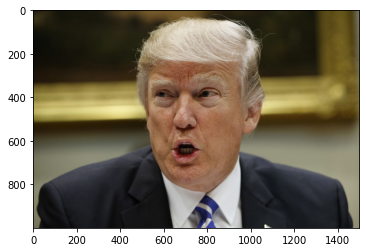

In [2]:
idx = random.randint(0, 20)
img = Image.open(f"images/Donald Trump/Image_{idx}.jpg")
plt.imshow(img);

Скачаем facial landmark detector и создадим объекты detector для определения bounding box и predictor для определения landmarks:

In [4]:
# ! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# ! bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

Проверим работу детектора на произвольных 12 изображениях

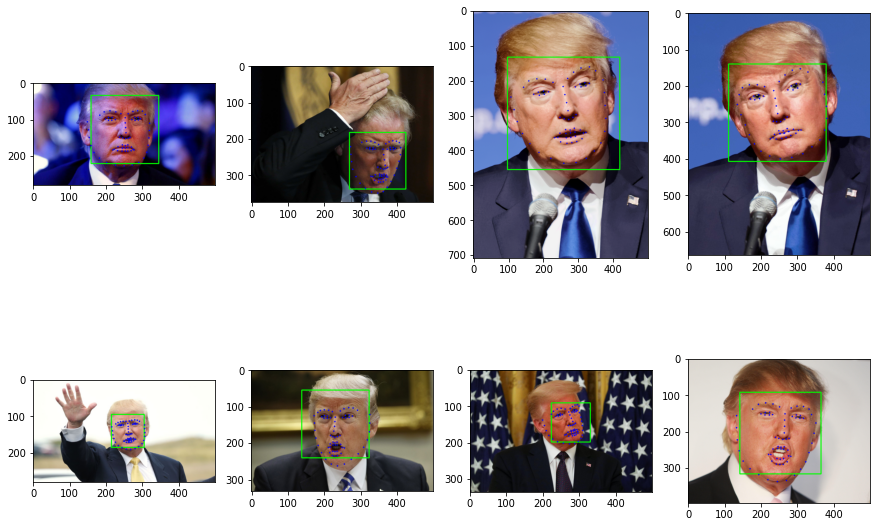

In [4]:
idx_list = random.sample(range(1, 21), k=8)

fig, axx = plt.subplots(2, 4, figsize=(15, 10))

for i, idx in enumerate(idx_list):
    image = cv2.imread(f"images/Donald Trump/Image_{idx}.jpg")
    image = imutils.resize(image, width=500)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
       
    # make image GRAY
    image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # draw detection
    rect = detector(image_gray, 1)
    if len(rect) > 0:
        # draw rectangle
        (x, y, w, h) = rect_to_bb(rect[0])
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
           
        # draw landmarks   
        shape = predictor(image_gray, rect[0])
        for (x, y) in shape_to_np(shape):
            cv2.circle(image, (x, y), 2, (0, 0, 255), -1)
    
    axx[i // 4, i % 4].imshow(image)

## 2.  Оценка метрик и валидация моделей

Загрузим изображения из тренировочного датасета kaggle-соревнования <a href=https://www.kaggle.com/c/facial-keypoints-detection/data> Kaggle: Facial Keypoints Detection </a>:

In [5]:
df = pd.read_csv("kaggle_facial_keypoints_detection/training.csv")

In [6]:
df.shape

(7049, 31)

В обучающей выборке 7049 изображений, для каждого из которых заданы координаты 15 ключевых точек и изображение в формате списка интенсивностей 96х96 пикселей.

Для удобства работы с данными напишем функцию, которая для каждой строки датафрейма будет возвращать изображение в виде numpy array размера (96, 96), и координаты точек (ground truth) также np.array размера (15, 2):

In [7]:
def series_to_ex(ser: pd.Series) -> Tuple[np.array, np.array]:
    
    image = np.array(list(map(int, ser["Image"].split())), dtype=np.uint8).reshape((96, 96))
        
    gt = np.array(ser.iloc[:-1].to_list(), dtype=np.float32).reshape((15, 2))
    return image, gt

Посмотрим, есть пропуски в данных:

In [8]:
df.isna().any(axis=0)

left_eye_center_x             True
left_eye_center_y             True
right_eye_center_x            True
right_eye_center_y            True
left_eye_inner_corner_x       True
left_eye_inner_corner_y       True
left_eye_outer_corner_x       True
left_eye_outer_corner_y       True
right_eye_inner_corner_x      True
right_eye_inner_corner_y      True
right_eye_outer_corner_x      True
right_eye_outer_corner_y      True
left_eyebrow_inner_end_x      True
left_eyebrow_inner_end_y      True
left_eyebrow_outer_end_x      True
left_eyebrow_outer_end_y      True
right_eyebrow_inner_end_x     True
right_eyebrow_inner_end_y     True
right_eyebrow_outer_end_x     True
right_eyebrow_outer_end_y     True
nose_tip_x                   False
nose_tip_y                   False
mouth_left_corner_x           True
mouth_left_corner_y           True
mouth_right_corner_x          True
mouth_right_corner_y          True
mouth_center_top_lip_x        True
mouth_center_top_lip_y        True
mouth_center_bottom_

В столбце Image и координатах кончика носа нет пропусков, в остальных столбцах - есть, то есть точки могут отсутствовать на изображении.

Посмотрим, как распределено количество точек на изображении:

In [9]:
n_landmarks = (15 - df.iloc[:, :-1].isna().sum(axis=1) / 2).astype(np.int8)

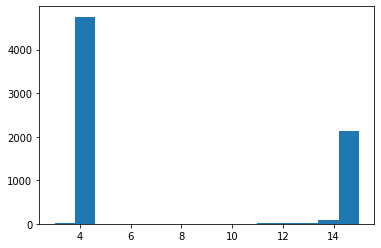

In [10]:
plt.hist(n_landmarks, bins=15);

Большинство изображений имеют только 4 ключевые точки, только чуть более 2000 изображений размечены полностью.

Вспомогательные функции:

- генератор, выдающий заданное количество пар изображение + ground truth разметка
- функция для визуализации

In [11]:
def sample_examples(data: pd.DataFrame, size: int = 10) -> Tuple[np.array, np.array]:
    assert size <= data.shape[0], "Sample size must be less or equal dataframe shape in 0 dimention"
    
    sample = data.sample(size)  #.reset_index(drop=True)
    
    for i in sample.index:
        image = np.array(list(map(int, sample.loc[i, "Image"].split())), dtype=np.uint8).reshape((96, 96))
        
        gt = np.array(sample.loc[i].iloc[:-1].to_list(), dtype=np.float32).reshape((15, 2))
        yield i, image, gt

In [12]:
def vizualize(data: pd.DataFrame, sample: bool = True, size: int = 12, grid: Tuple[int, int] = (3, 4)) -> None:
    
    sample_size = size if sample else data.shape[0]
        
    examples = sample_examples(data, size=sample_size)
        
        
    for i, (idx, image, gt) in enumerate(examples):

        # make image RGB
        image_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

        # draw ground truth
        for pt in range(15):
            if not np.isnan(gt[pt]).any():
                cv2.circle(image_rgb, (int(gt[pt, 0]), int(gt[pt, 1])), 1, (255, 0, 0), -1)

        # draw prediction
        rect = detector(image, 1)

        # if detector doesn't find a face, all image will be a bbox
        if len(rect) == 0:
            rect = dlib.rectangles(1)
            rect[0] = dlib.rectangle(0, 0, 95, 95)

        shape = predictor(image, rect[0])
        for (x, y) in shape_to_np_15points(shape):
            if x is not None and y is not None:
                cv2.circle(image_rgb, (x, y), 1, (0, 0, 255), -1)

        axx[i // grid[1], i % grid[1]].imshow(image_rgb)
        axx[i // grid[1], i % grid[1]].set_title(f"index {idx}")
    

Визуализируем 12 произвольных изображений с ground truth разметкой и facial landmark detector разметкой:

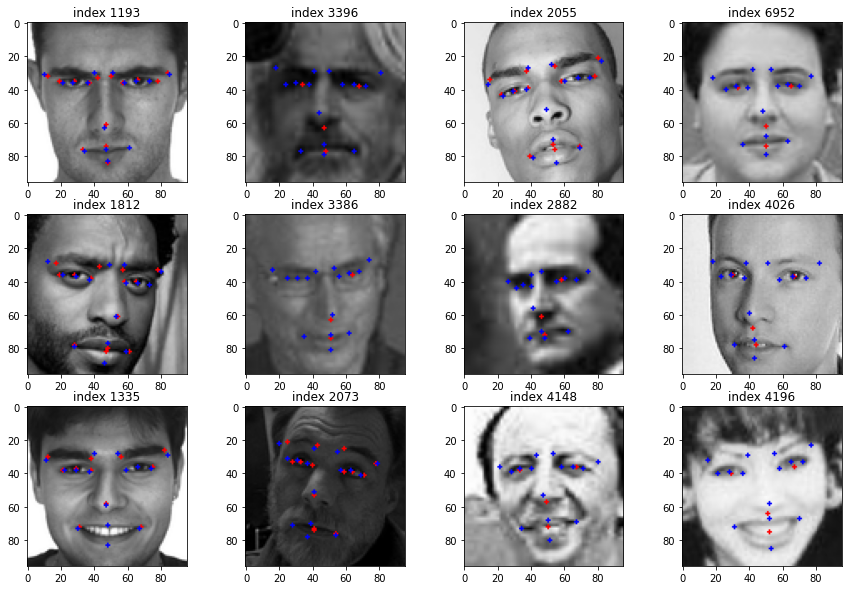

In [13]:
fig, axx = plt.subplots(3, 4, figsize=(15, 10))

vizualize(df)

Видно, что часто не все точки присутствуют на ground truth разметке (красные точки), найденные детектором точки (синие) несколько отличаются от истинной разметки.

### Метрики

Для оценки точности детектирования отдельной точки удобно использовать евклидово расстояние между точками.
Среднее качество по всем точкам можно вычислить как среднее арифметическое этих расстояний.

Кроме того, нужно оценить, находит ли детектор все точки, которые есть в ground truth разметке. Для этого для каждого лица можно вычислить recall - долю точек grund truth, найденную детектором.

Точность позиционирования лица должна зависеть от расстояния между разметками и полноты (recall).

В случае, если детектор не нашел лица на изображении и не предсказал ни одной точки, recall будет равен 0, точность позиционирования также будет нулевая.

Если же детектор нашел лицо, но расстояние между предсказанной и истинной разметкой большое, то метрика также должна иметь низкое значение.
Если детектор нашел все точки и расстояние между точками равно 0, то точность позиционирования будет максимальная.
Также среднее расстояние между точками можно отнормировать на размер изображения - так эта величина не будет зависеть от размера изображения в случае, если набор данных состоит из изображений разного разрешения.

В качестве метрики можно рассмотреть отношение
$$ \frac{recall}{\frac{\frac{1}{n} \sum_{i \in gt, pred} d_i}{\sqrt{w}} + 1} $$

где $ d_i $ - расстояние между метками точки i;
    $ w $ - ширина изображения

Эта метрика будет иметь значения в промежутке [0, 1]


Вычислим значение метрики для каждого изображения:

In [14]:
def calc_image_score(image: np.array, gt: np.array) -> float:
    
    # make detection
    rect = detector(image, 1)
    
    # if detector doesn't find a face, all image will be a bbox
    if len(rect) == 0:
        rect = dlib.rectangles(1)
        rect[0] = dlib.rectangle(0, 0, 95, 95)

    shape = predictor(image, rect[0])
    pred = shape_to_np_15points(shape)

    # calc recall
    gt_bool = ~np.isnan(gt).any(axis=1)
    both_bool = gt_bool * (~np.isnan(pred).any(axis=1))
    recall = both_bool.sum() / gt_bool.sum()
    
    # calc mean of distance
    d_mean = np.nanmean(((gt - pred) ** 2).sum(axis=1) ** 0.5)
    
    # width of the image
    w = image.shape[0]
    
    return recall / (d_mean / w ** 0.5 + 1)


def calc_score(ser: pd.Series) -> float:
    image, gt = series_to_ex(ser)
    return calc_image_score(image, gt)

In [15]:
scores = df.apply(calc_score, axis=1)

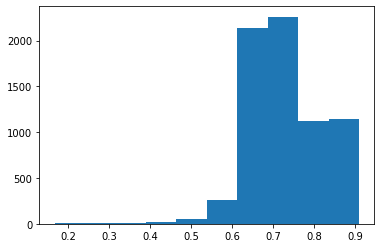

In [16]:
plt.hist(scores);

Большинство изображений имеют хорошую точность разметки - от 0.6 до 0.9.

Отсортируем изображения по величине метрики и выберем по 8 изображений с наилучшим и наихудшим качеством:

In [17]:
scores.sort_values(inplace=True)

In [18]:
worse_objects = df.iloc[scores[:8].index]
best_objects = df.iloc[scores[-8:].index]

Изображения с наихудшим качеством разметки:

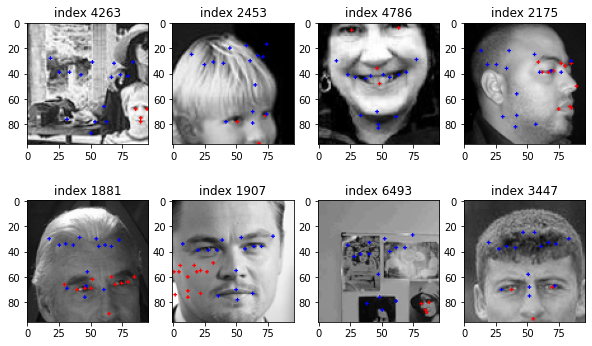

In [19]:
fig, axx = plt.subplots(2, 4, figsize=(10, 6))

vizualize(worse_objects, sample=False, size=8, grid=(2, 4))

В основном на этих примерах лицо либо изображено не полностью, либо не фронтально, либо экспертная разметка выполнена некачетсвенно.

Посмотрим на примеры с наилучшим качеством детекции точек:

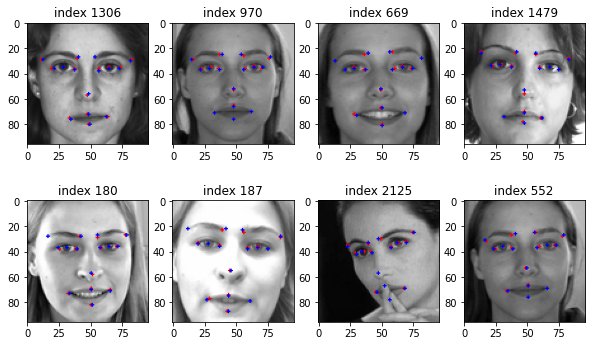

In [20]:
fig, axx = plt.subplots(2, 4, figsize=(10, 6))

vizualize(best_objects, sample=False, size=8, grid=(2, 4))

## 3. Работа с инструментами разметки

In [21]:
import supervisely as sly
from supervise_token import token

address = 'https://app.supervise.ly/'
api = sly.Api(address, token)

Для отправки изображений на разметку в supervise.ly, создадим проект и датасет:

In [9]:
# create project and dataset
project = api.project.create(workspace_id=84762, name="landmark project")
dataset = api.dataset.create(project.id, "dataset-01")

In [22]:
project_id = 240536
dataset_id = 777695

Для каждого типа точки создадим отдельный класс (всего из будет 15), добавим классы объектов в проект:

In [23]:
left_eye_center_class = sly.ObjClass("left_eye_center", sly.Point, color=[0, 255, 0])
right_eye_center_class = sly.ObjClass("right_eye_center", sly.Point, color=[255, 0, 0])
left_eye_inner_corner_class = sly.ObjClass("left_eye_inner_corner", sly.Point, color=[0, 0, 255])
left_eye_outer_corner_class = sly.ObjClass("left_eye_outer_corner", sly.Point, color=[255, 95, 208])
right_eye_inner_corner_class = sly.ObjClass("right_eye_inner_corner", sly.Point, color=[160, 32, 255])
right_eye_outer_corner_class = sly.ObjClass("right_eye_outer_corner", sly.Point, color=[80, 208, 255])
left_eyebrow_inner_end_class = sly.ObjClass("left_eyebrow_inner_end", sly.Point, color=[0, 32, 55])
left_eyebrow_outer_end_class = sly.ObjClass("left_eyebrow_outer_end", sly.Point, color=[96, 255, 128])
right_eyebrow_inner_end_class = sly.ObjClass("right_eyebrow_inner_end", sly.Point, color=[255, 224, 32])
right_eyebrow_outer_end_class = sly.ObjClass("right_eyebrow_outer_end", sly.Point, color=[255, 208, 160])
nose_tip_class = sly.ObjClass("nose_tip", sly.Point, color=[55, 205, 40])
mouth_left_corner_class = sly.ObjClass("mouth_left_corner", sly.Point, color=[128, 255, 40])
mouth_right_corner_class = sly.ObjClass("mouth_right_corner", sly.Point, color=[5, 128, 40])
mouth_center_top_lip_class = sly.ObjClass("mouth_center_top_lip", sly.Point, color=[5, 75, 255])
mouth_center_bottom_lip_class = sly.ObjClass("mouth_center_bottom_lip", sly.Point, color=[5, 130, 255])

In [24]:
project_meta = sly.ProjectMeta(obj_classes=[left_eye_center_class, right_eye_center_class,
                                           left_eye_inner_corner_class, left_eye_outer_corner_class,
                                           right_eye_inner_corner_class, right_eye_outer_corner_class,
                                           left_eyebrow_inner_end_class, left_eyebrow_outer_end_class,
                                           right_eyebrow_inner_end_class, right_eyebrow_outer_end_class,
                                           nose_tip_class, mouth_left_corner_class, mouth_right_corner_class,
                                           mouth_center_top_lip_class, mouth_center_bottom_lip_class])

In [25]:
api.project.update_meta(project_id, project_meta)

Создадим файлы с изображениями и аннотациями. Для этого потребуется функция, создающая объект аннотации по массиву точек разметки:

In [26]:
classes = {0: "left_eye_center", 1: "right_eye_center", 2: "left_eye_inner_corner", 
        3: "left_eye_outer_corner", 4: "right_eye_inner_corner", 
        5: "right_eye_outer_corner", 6: "left_eyebrow_inner_end",
       7: "left_eyebrow_outer_end", 8: "right_eyebrow_inner_end", 9: "right_eyebrow_outer_end",
       10: "nose_tip", 11: "mouth_left_corner", 12: "mouth_right_corner",
       13: "mouth_center_top_lip", 14: "mouth_center_bottom_lip"}

def shape_to_ann_object(arr: np.array, name: str) -> dict:
    ann = {
        "description": "facial_landmarks",
        "name": name,
        "size": {
            "width": 96,
            "height": 96
        },
        "tags": [],
        "objects": []
    }
    
    for i in range(arr.shape[0]):
        if not np.isnan(arr[i]).any():
            ann["objects"].append({
                                    "description": "",
                                    "geometryType": "point",
                                    "tags": [],
                                    "classTitle": classes[i],
                                    "points": {
                                    "exterior": [
                                        [
                                            int(arr[i][0]),
                                            int(arr[i][1])
                                        ]
                                     ],
                                    "interior": []
                                    }
                                 })
    return ann
    

Выберем 10 случайных изображений и запишем их в формате jpeg, аннотации к ним - в формате json:

In [ ]:
import json

for i, image, _ in sample_examples(df, size=10):
    filename = f"image_{i}.jpeg"
    cv2.imwrite(os.path.join("images/Ann_images/", filename), image)
    
    # make detection
    rect = detector(image, 1)
    
    # if detector doesn't find a face, all image will be a bbox
    if len(rect) == 0:
        rect = dlib.rectangles(1)
        rect[0] = dlib.rectangle(0, 0, 95, 95)

    shape = predictor(image, rect[0])
    pred = shape_to_np_15points(shape)
    
    with open(f"images/Ann/ann_{i}.json", "w") as f:
        json.dump(shape_to_ann_object(pred, filename), f)

Добавим изображения с аннотациями в датасет на supervise.ly:

In [28]:
# upload data
img_names = os.listdir("images/Ann_images")
workdir = os.getcwd()
img_paths = [os.path.join(workdir, "images/Ann_images", name) for name in img_names]

img_infos = api.image.upload_paths(dataset.id, names=img_names, paths=img_paths)

In [29]:
# api.annotation.upload_path(image_info.id, "/Users/max/ann.json")
img_ids = [img.id for img in img_infos]
ann_jsons = [json.load(open(os.path.join(workdir, "images/Ann", 
                                         "ann_" + img.name[6:-5] + ".json"))) for img in img_infos]
api.annotation.upload_jsons(img_ids, ann_jsons)

Скриншот сервиса с примером:

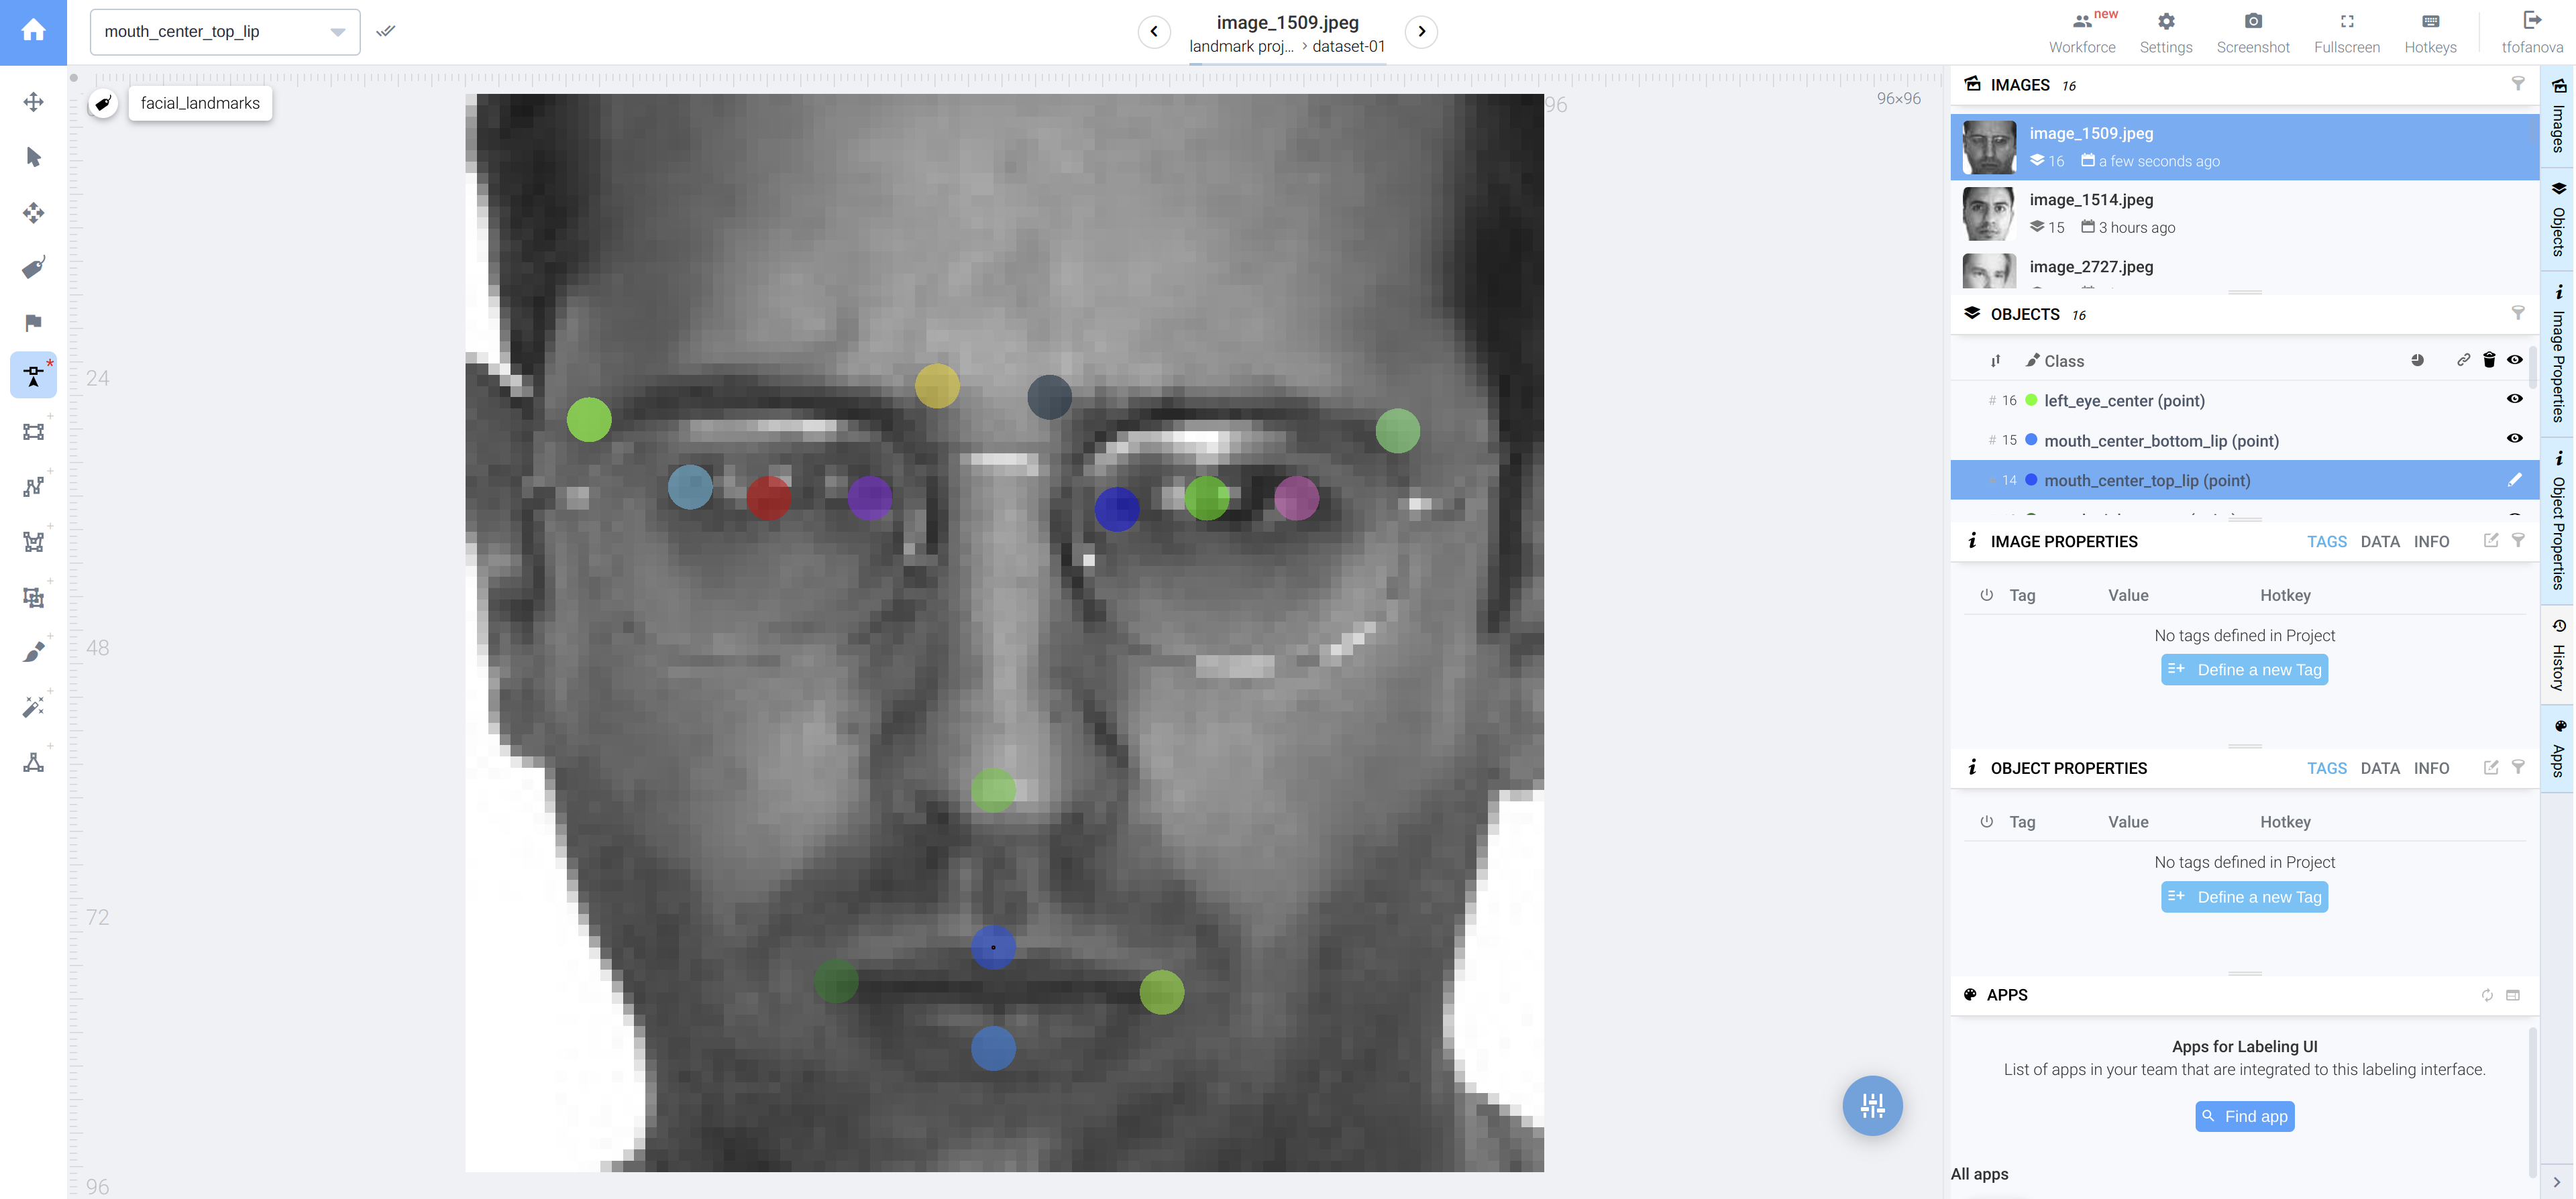

### Время разметки

Сервис supervise.ly также предоставляет статистику по действиям пользователя в формате csv, по этой статистике можно вычислить время, потраченное на разметку каждого изображения:


In [30]:
stat = pd.read_csv("513910_240536_activity.csv", usecols=[0, 1, 2, 11])
stat.date = pd.to_datetime(stat.date)
stat.head()

,userId,action,date,image
0,69848,annotation_duration,2023-04-19 11:26:52.889000+00:00,image_527.jpeg
1,69848,annotation_duration,2023-04-19 11:27:22.938000+00:00,image_527.jpeg
2,69848,annotation_duration,2023-04-19 11:31:34.345000+00:00,image_527.jpeg
3,69848,annotation_duration,2023-04-19 11:56:34.620000+00:00,image_527.jpeg
4,69848,annotation_duration,2023-04-19 11:57:04.981000+00:00,image_527.jpeg


Разметка с нуля выполнялась для изображения image_6486.jpeg, доразметка - для image_6758.jpeg. Оставим в данных строки, относящиеся только к этим двум изображениям:

In [31]:
stat = stat[stat.image.isin(["image_6486.jpeg", "image_6758.jpeg"])]

Посмотрим, какие типы действий совершались:

In [32]:
stat.action.unique()

array(['create_figure', 'annotation_duration', 'update_figure'],
      dtype=object)

Оставим только записи с действием "annotation_duration":

In [33]:
stat = stat[stat.action == "annotation_duration"]

Вычислим время разметки как разницу между первым и последнем timestamp в секундах:

In [34]:
stat.groupby("image").agg({"date": lambda s: (s.max() - s.min()).seconds})

,date
image,
image_6486.jpeg,126
image_6758.jpeg,11


Разметка с нуля заняла 126 секунд, доразметка - 12 секунд. 

При разметке с нуля для каждого типа точки приходилось каждый раз выбирать ее класс из списка, в то время как при доразметке нужно было только подвинуть часть точек, что значительно быстрее.